In [1]:
import ambulance_game as abg
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt
import scipy.optimize

# Functions to be modularised

In [35]:
def get_mean_blocking_difference_between_two_systems_markov(
    prop_1,
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    num_of_servers_1,
    num_of_servers_2,
    threshold_1,
    threshold_2,
    system_capacity_1,
    system_capacity_2,
    buffer_capacity_1,
    buffer_capacity_2,
):
    """
    Get the mean blocking difference between two Markov chains 
    """
    lambda_2_1 = prop_1 * lambda_2
    lambda_2_2 = (1 - prop_1) * lambda_2

    mean_blocking_1 = abg.markov.get_mean_blocking_time_using_markov_state_probabilities(
        lambda_2=lambda_2_1,
        lambda_1=lambda_1_1,
        mu=mu_1,
        num_of_servers=num_of_servers_1,
        threshold=threshold_1,
        system_capacity=system_capacity_1,
        buffer_capacity=buffer_capacity_1,
    )
    mean_blocking_2 = abg.markov.get_mean_blocking_time_using_markov_state_probabilities(
        lambda_2=lambda_2_2,
        lambda_1=lambda_1_2,
        mu=mu_2,
        num_of_servers=num_of_servers_2,
        threshold=threshold_2,
        system_capacity=system_capacity_2,
        buffer_capacity=buffer_capacity_2,
    )
    return mean_blocking_1 - mean_blocking_2

In [34]:
def make_plot_two_hospitals_arrival_split_markov(
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    num_of_servers_1,
    num_of_servers_2,
    threshold_1,
    threshold_2,
    system_capacity_1,
    system_capacity_2,
    buffer_capacity_1,
    buffer_capacity_2,
    accuracy=10,
):
    """
    Plot for the arrivals split between two hospitals using the markov model
    """
    hospital_times_1 = []
    hospital_times_2 = []
    all_arrival_rates = np.linspace(0, lambda_2, accuracy + 1)
    for arrival_rate_1 in all_arrival_rates[1:-1]:
        arrival_rate_2 = lambda_2 - arrival_rate_1
        times_1 = abg.markov.get_mean_blocking_time_using_markov_state_probabilities(
            lambda_2=arrival_rate_1,
            lambda_1=lambda_1_1,
            mu=mu_1,
            num_of_servers=num_of_servers_1,
            threshold=threshold_1,
            system_capacity=system_capacity_1,
            buffer_capacity=buffer_capacity_1,
        )
        times_2 = abg.markov.get_mean_blocking_time_using_markov_state_probabilities(
            lambda_2=arrival_rate_2,
            lambda_1=lambda_1_2,
            mu=mu_2,
            num_of_servers=num_of_servers_2,
            threshold=threshold_2,
            system_capacity=system_capacity_2,
            buffer_capacity=buffer_capacity_2,
        )
        hospital_times_1.append(times_1)
        hospital_times_2.append(times_2)
        
    x_labels = all_arrival_rates[1:-1] / all_arrival_rates[-1]
    plt.figure(figsize=(23, 10))
    waiting_time_plot = plt.plot(x_labels, hospital_times_1, ls="solid", lw=1.5)
    plt.plot(x_labels, hospital_times_2, ls="solid", lw=1.5)
    plt.legend(["Hospital 1", "Hospital 2"], fontsize="x-large")
    plt.title("Blocking times of two systems ($T_1$=" + str(threshold_1) + ", $T_2$=" + str(threshold_2) + ")", fontsize=18)
    plt.ylabel("Blocking Time", fontsize=15, fontweight="bold")
    plt.xlabel(f"$p_1$", fontsize=15, fontweight="bold")

    return waiting_time_plot

In [37]:
def calculate_class_2_individuals_best_response_markov(
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    num_of_servers_1,
    num_of_servers_2,
    threshold_1,
    threshold_2,
    system_capacity_1,
    system_capacity_2,
    buffer_capacity_1,
    buffer_capacity_2,
    lower_bound=0.01,
    upper_bound=0.99,
):
    """
    Get the best response of class 2 individuals given two thresholds
    """
    check_1 = get_mean_blocking_difference_between_two_systems_markov(
        prop_1=lower_bound,
        lambda_2=lambda_2,
        lambda_1_1=lambda_1_1,
        lambda_1_2=lambda_1_2,
        mu_1=mu_1,
        mu_2=mu_2,
        num_of_servers_1=num_of_servers_1,
        num_of_servers_2=num_of_servers_2,
        threshold_1=threshold_1,
        threshold_2=threshold_2,
        system_capacity_1=system_capacity_1,
        system_capacity_2=system_capacity_2,
        buffer_capacity_1=buffer_capacity_1,
        buffer_capacity_2=buffer_capacity_2
    )
    check_2 = get_mean_blocking_difference_between_two_systems_markov(
        prop_1=upper_bound,
        lambda_2=lambda_2,
        lambda_1_1=lambda_1_1,
        lambda_1_2=lambda_1_2,
        mu_1=mu_1,
        mu_2=mu_2,
        num_of_servers_1=num_of_servers_1,
        num_of_servers_2=num_of_servers_2,
        threshold_1=threshold_1,
        threshold_2=threshold_2,
        system_capacity_1=system_capacity_1,
        system_capacity_2=system_capacity_2,
        buffer_capacity_1=buffer_capacity_1,
        buffer_capacity_2=buffer_capacity_2
    )

    if check_1 >= 0 and check_2 >= 0:
        return 0
    if check_1 <= 0 and check_2 <= 0:
        return 1

    optimal_prop = scipy.optimize.brentq(
        get_mean_blocking_difference_between_two_systems_markov,
        a=lower_bound,
        b=upper_bound,
        args=(
            lambda_2,
            lambda_1_1,
            lambda_1_2,
            mu_1,
            mu_2,
            num_of_servers_1,
            num_of_servers_2,
            threshold_1,
            threshold_2,
            system_capacity_1,
            system_capacity_2,
            buffer_capacity_1,
            buffer_capacity_2,
        ),
    )
    return optimal_prop

# Performance measures

In [23]:
lambda_2 = 2
lambda_1 = 3
mu = 3
num_of_servers = 2
threshold = 10
system_capacity = 20
buffer_capacity = 10

seed_num = 0
num_of_trials = 10
runtime = 2000
class_type = None

## Waiting time - Simulation

In [24]:
times = abg.simulation.get_multiple_runs_results(
    lambda_2=lambda_2, 
    lambda_1=lambda_1, 
    mu=mu, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    seed_num=seed_num, 
    num_of_trials=num_of_trials, 
    runtime=runtime,  
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity, 
    class_type=class_type,
)
np.mean([np.mean(w.waiting_times) for w in times])

0.6022084546856334

## Waiting Time - Markov Chain

In [25]:
abg.markov.get_mean_waiting_time_using_markov_state_probabilities(
    lambda_2=lambda_2, 
    lambda_1=lambda_1, 
    mu=mu, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity, 
    class_type=class_type, 
)

0.6012303276456343

## Blocking Time - Simulation

In [26]:
np.mean([np.mean(b.blocking_times) for b in times])

0.25007666898787567

## Blocking Time -  Markov Chain

In [27]:
abg.markov.get_mean_blocking_time_using_markov_state_probabilities(
    lambda_2=lambda_2, 
    lambda_1=lambda_1, 
    mu=mu, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity, 
)

0.23536493650687704

# Mean blocking difference between two systems $B_1 - B_2$

In [30]:
lambda_2 = 5

lambda_1_1 = 3
mu_1 = 3
num_of_servers_1 = 2
threshold_1 = 10
system_capacity_1 = 20
buffer_capacity_1 = 10

lambda_1_2 = 3
mu_2 = 3
num_of_servers_2 = 2
threshold_2 = 10
system_capacity_2 = 20
buffer_capacity_2 = 10

seed_num_1 = 0
seed_num_2 = 1

warm_up_time = 100
num_of_trials = 3
runtime = 2000
class_type = None

In [12]:
mean_blocking_difference_markov = get_mean_blocking_difference_between_two_systems_markov(
    prop_1=0.5,
    lambda_2=lambda_2,
    lambda_1_1=lambda_1_1,
    lambda_1_2=lambda_1_2,
    mu_1=mu_1,
    mu_2=mu_2,
    num_of_servers_1=num_of_servers_1,
    num_of_servers_2=num_of_servers_2,
    threshold_1=threshold_1,
    threshold_2=threshold_2,
    system_capacity_1=system_capacity_1,
    system_capacity_2=system_capacity_2,
    buffer_capacity_1=buffer_capacity_1,
    buffer_capacity_2=buffer_capacity_2,
)
mean_blocking_difference_markov

0.0

# Optimal distribution of class 2 individuals

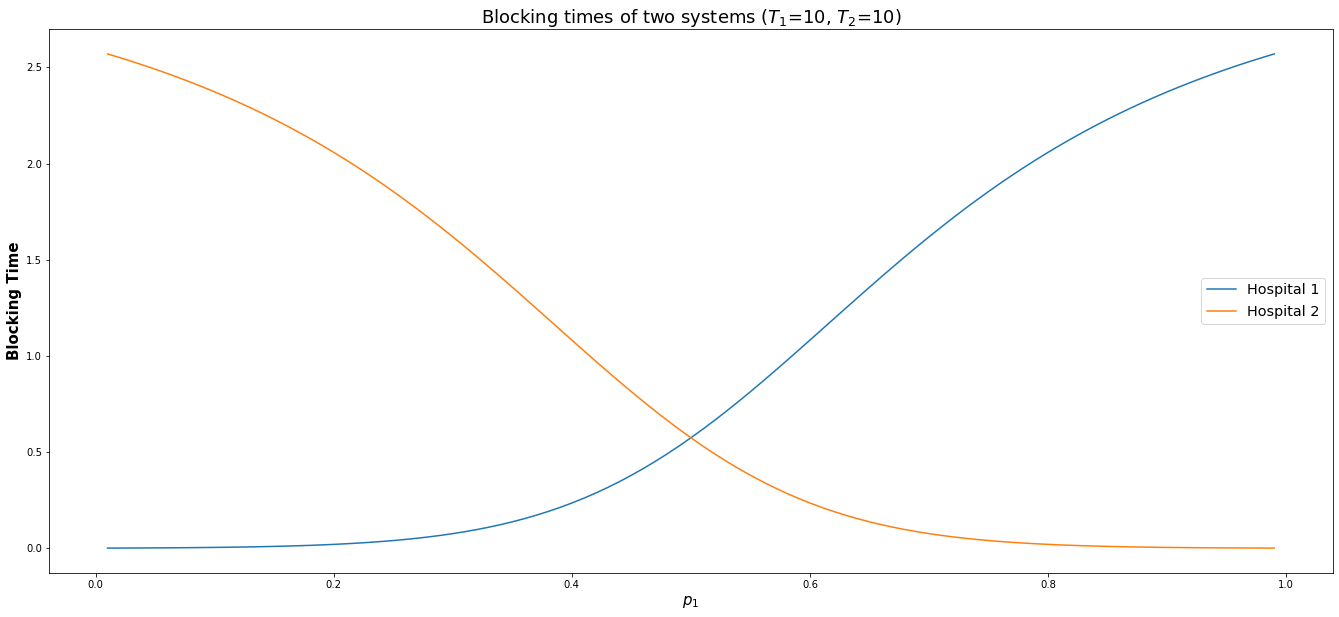

In [14]:
make_plot_two_hospitals_arrival_split_markov(
    lambda_2=lambda_2,
    lambda_1_1=lambda_1_1,
    lambda_1_2=lambda_1_2,
    mu_1=mu_1,
    mu_2=mu_2,
    num_of_servers_1=num_of_servers_1,
    num_of_servers_2=num_of_servers_2,
    threshold_1=threshold_1,
    threshold_2=threshold_2,
    system_capacity_1=system_capacity_1,
    system_capacity_2=system_capacity_2,
    buffer_capacity_1=buffer_capacity_1,
    buffer_capacity_2=buffer_capacity_2,
    accuracy=100,
)

## Simulation

In [15]:
optimal_distribution = abg.simulation.calculate_class_2_individuals_best_response(
    lambda_2=lambda_2,
    lambda_1_1=lambda_1_1,
    lambda_1_2=lambda_1_2,
    mu_1=mu_1,
    mu_2=mu_2,
    num_of_servers_1=num_of_servers_1,
    num_of_servers_2=num_of_servers_2,
    threshold_1=threshold_1,
    threshold_2=threshold_2,
    system_capacity_1=system_capacity_1,
    system_capacity_2=system_capacity_2,
    buffer_capacity_1=buffer_capacity_1,
    buffer_capacity_2=buffer_capacity_2,
    seed_num_1=seed_num_1,
    seed_num_2=seed_num_2,
    num_of_trials=5,
    warm_up_time=warm_up_time,
    runtime=500,
)

In [16]:
optimal_distribution

0.4943136426991408

**For identical systems**:
- with the same random seeds:  $opt = 0.5$
- with different random seeds: $\lim_{t \rightarrow \infty} opt = 0.5$

## Markov chain

In [18]:
optimal_distribution = calculate_class_2_individuals_best_response_markov(
    lambda_2=lambda_2,
    lambda_1_1=lambda_1_1,
    lambda_1_2=lambda_1_2,
    mu_1=mu_1,
    mu_2=mu_2,
    num_of_servers_1=num_of_servers_1,
    num_of_servers_2=num_of_servers_2,
    threshold_1=threshold_1,
    threshold_2=threshold_2,
    system_capacity_1=system_capacity_1,
    system_capacity_2=system_capacity_2,
    buffer_capacity_1=buffer_capacity_1,
    buffer_capacity_2=buffer_capacity_2,
)

In [19]:
optimal_distribution

0.5

# Game thoretic model

In [20]:
lambda_2 = 0.6

lambda_1_1 = 0.1
mu_1 = 0.5
num_of_servers_1 = 2
system_capacity_1 = 5
buffer_capacity_1 = 6

lambda_1_2 = 0.1
mu_2 = 0.2
num_of_servers_2 = 5
system_capacity_2 = 5
buffer_capacity_2 = 6

seed_num_1 = 0
seed_num_2 = 0

warm_up_time = 100
num_of_trials = 2
runtime = 1000
class_type = None

## Strategies

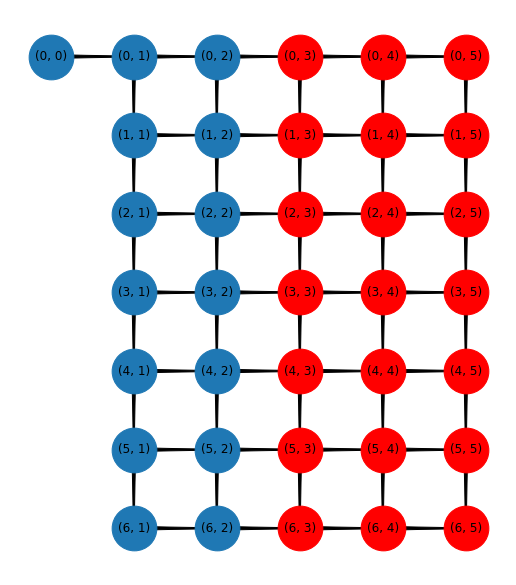

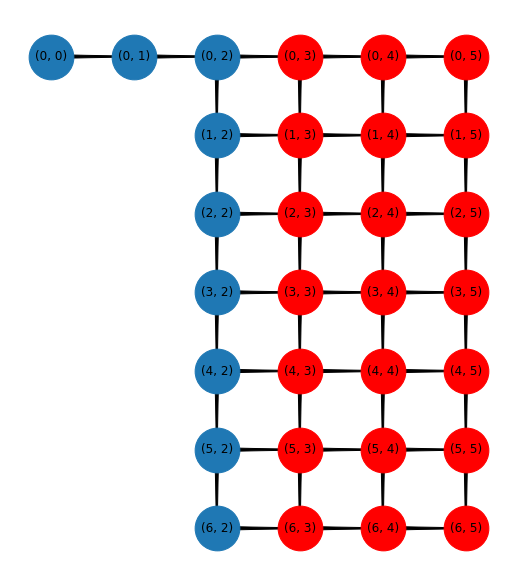

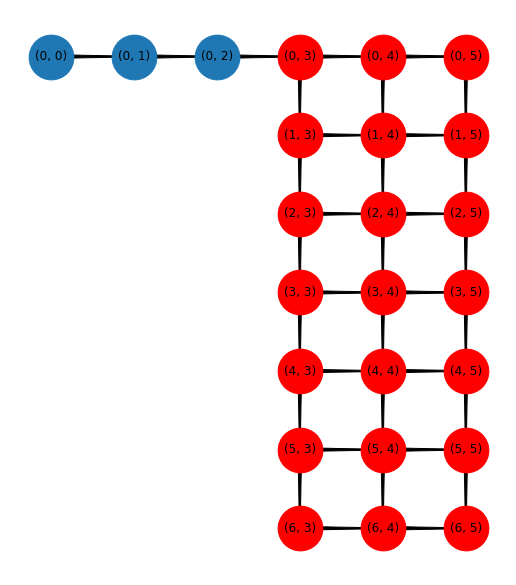

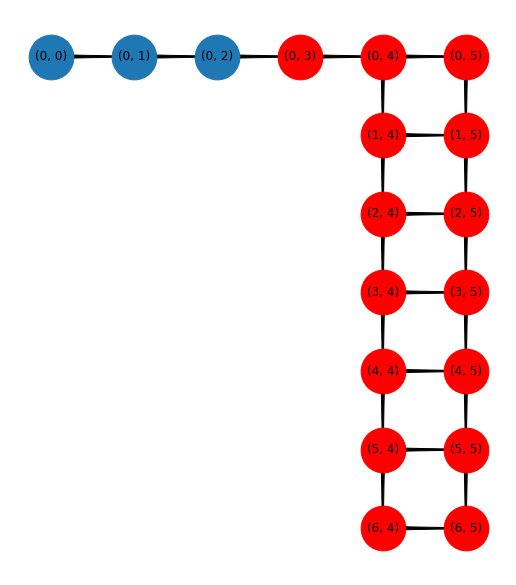

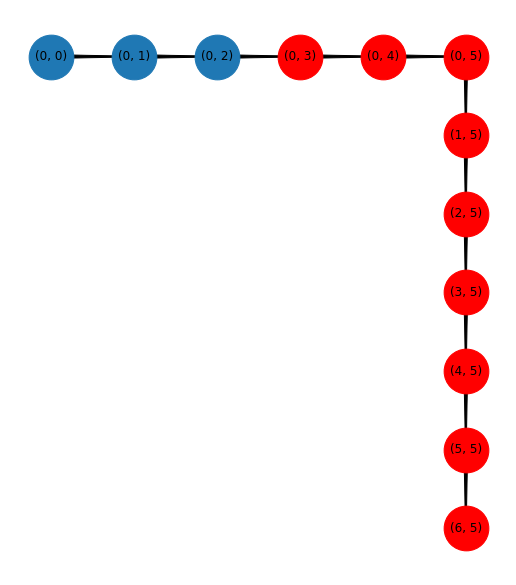

In [21]:
for t in range(1, system_capacity_1 + 1):
    abg.markov.visualise_markov_chain(num_of_servers=num_of_servers_1, threshold=t, system_capacity=system_capacity_1, buffer_capacity=buffer_capacity_1)

## Ambulance distribution proportions:

\begin{equation}
    P =
    \begin{pmatrix}
        p(B_{0}=B_{0}) & p(B_{0}=B_{1}) & p(B_{0}=B_{2}) & \dots & p(B_{0}=B_{N_2-1}) & p(B_{0}=B_{N_2}) \\
        p(B_{1}=B_{0}) & p(B_{1}=B_{1}) & p(B_{1}=B_{2}) & \dots & p(B_{1}=B_{N_2-1}) & p(B_{1}=B_{N_2}) \\
        p(B_{2}=B_{0}) & p(B_{2}=B_{1}) & p(B_{2}=B_{2}) & \dots & p(B_{2}=B_{N_2-1}) & p(B_{2}=B_{N_2}) \\
        \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
        p(B_{N_1-1}=B_0) & p(B_{N_1-1}=B_1) & p(B_{N_1-1}=B_2) & \dots & p(B_{N_1-1}=B_{N_2-1}) & p(B_{N_1-1}=B_{N_2}) \\
        p(B_{N_1}=B_0) & p(B_{N_1}=B_1) & p(B_{N_1}=B_2) & \dots & p(B_{N_1}=B_{N_2-1}) & p(B_{N_1}=B_{N_2}) 
    \end{pmatrix}, \;
    p_1 = P[T_1, T_2], \;
    p_2 = 1 - p_1
\end{equation}


### Using Simulation

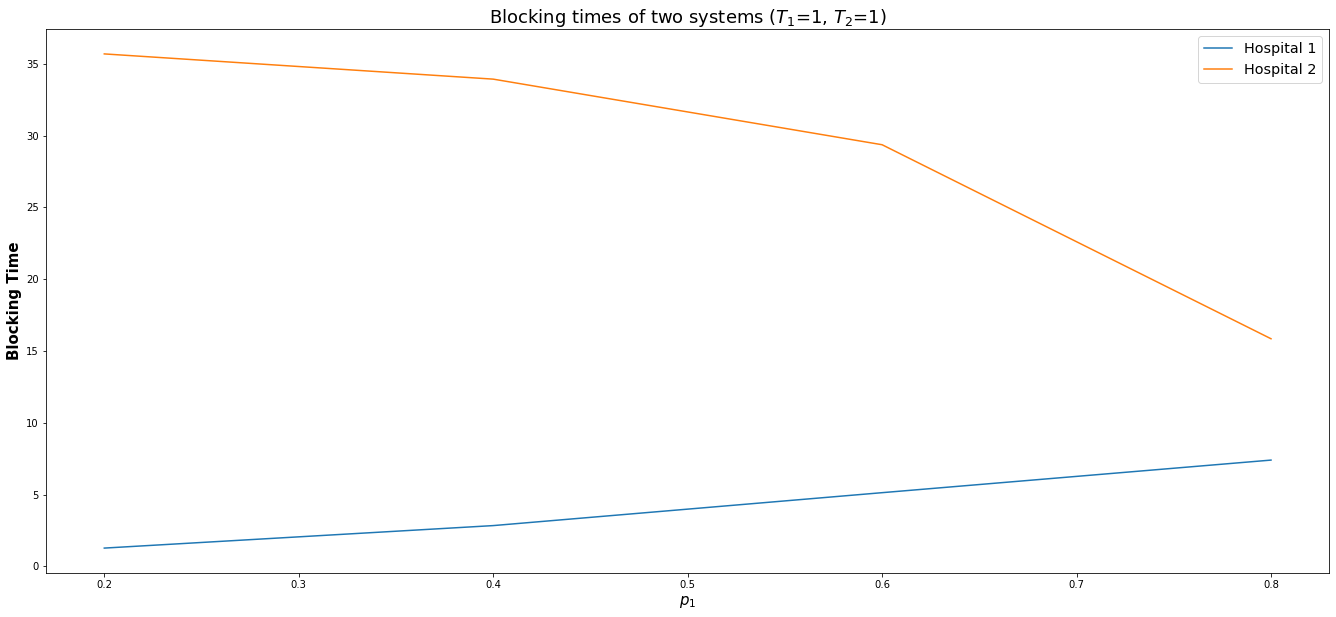

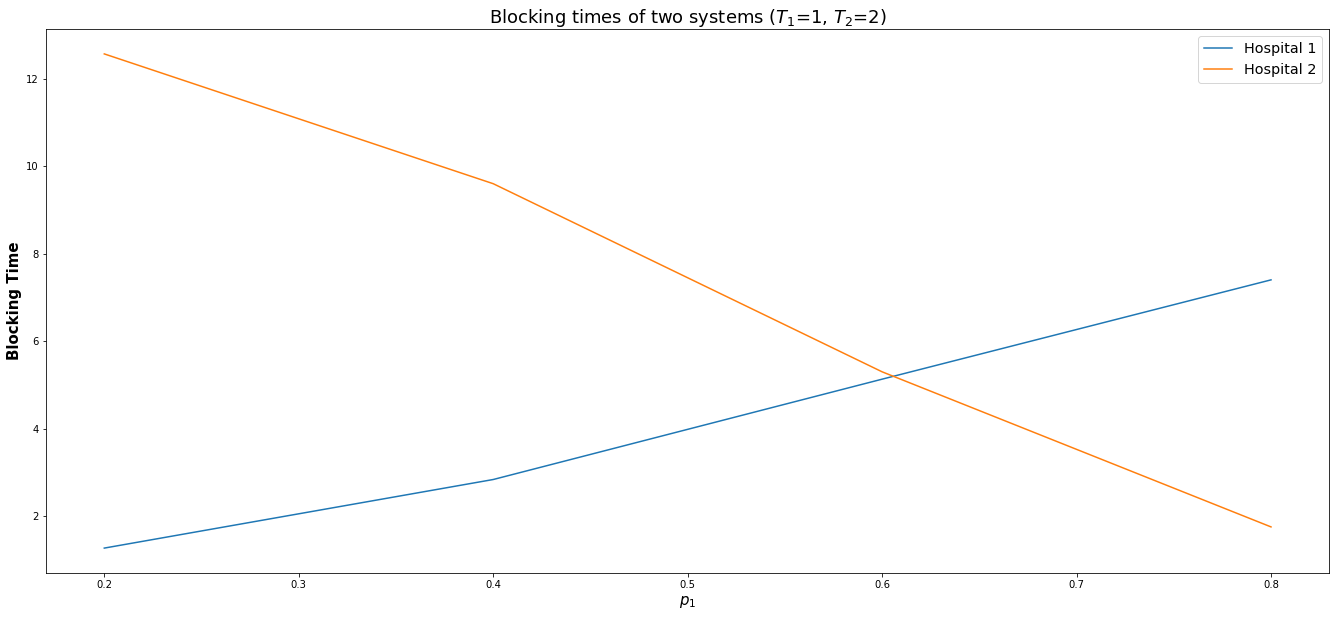

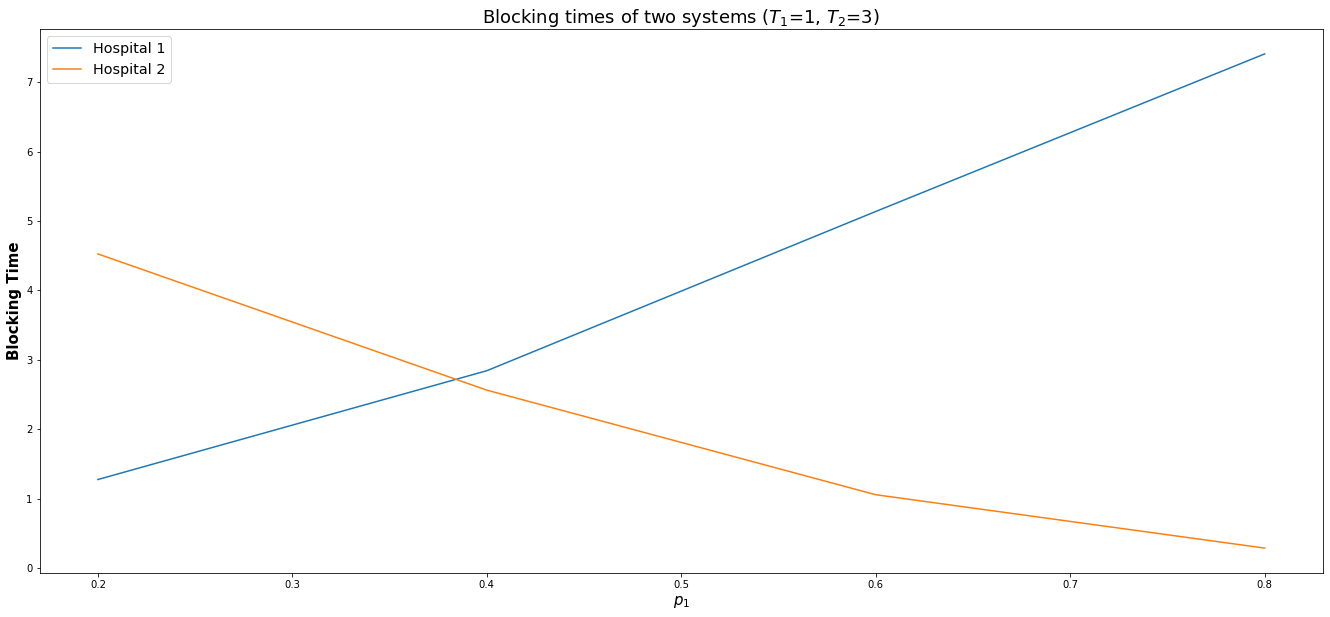

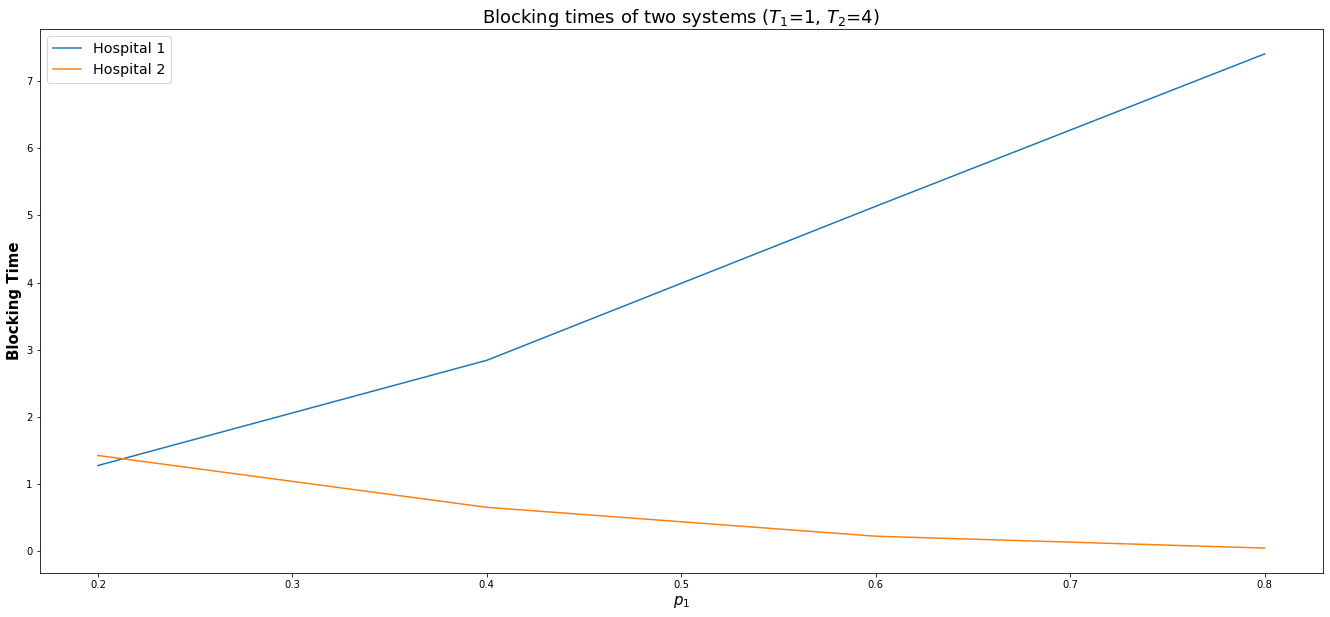

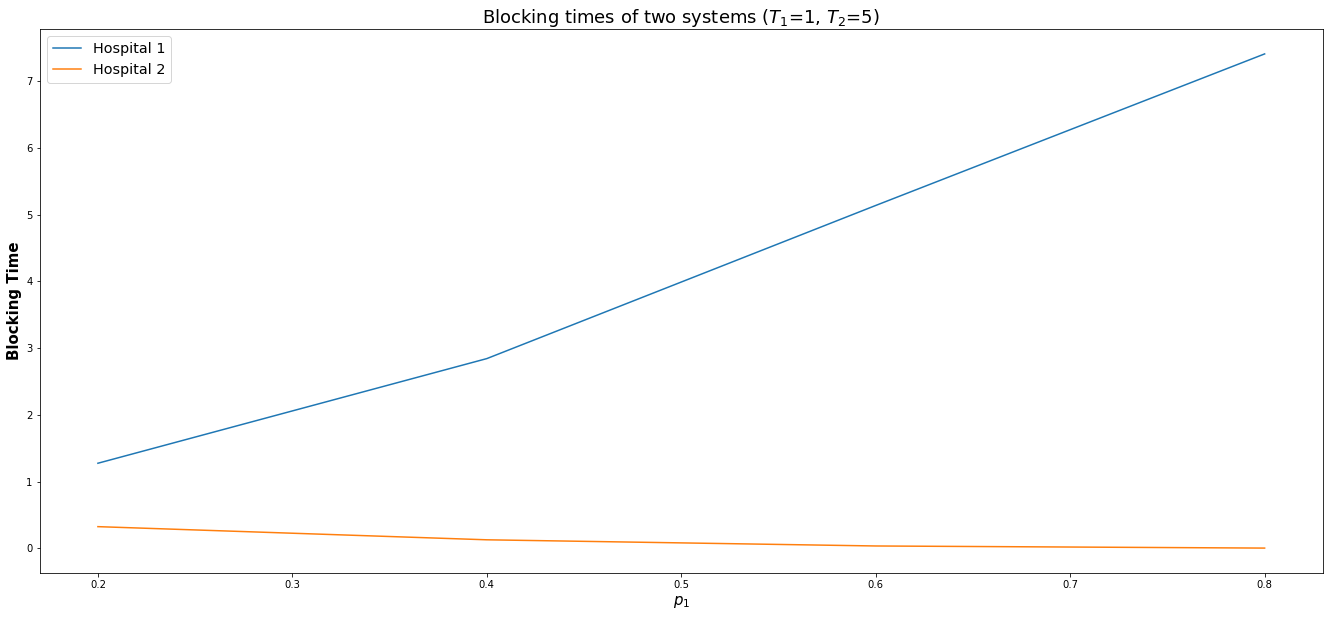

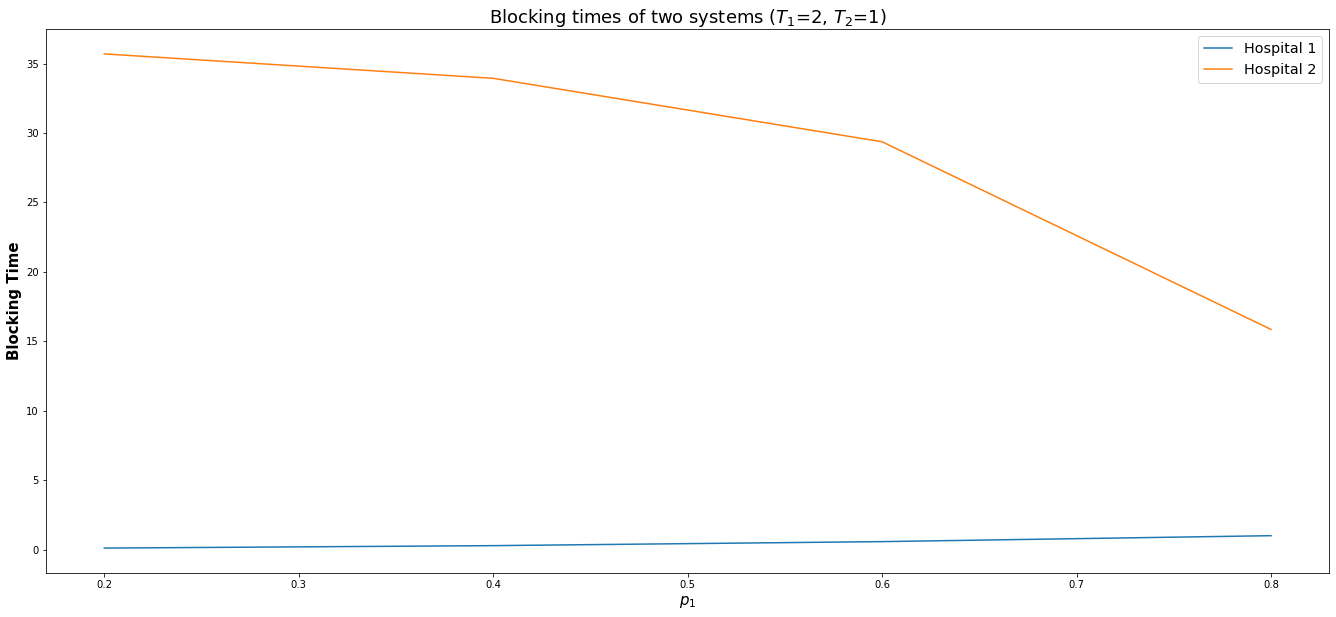

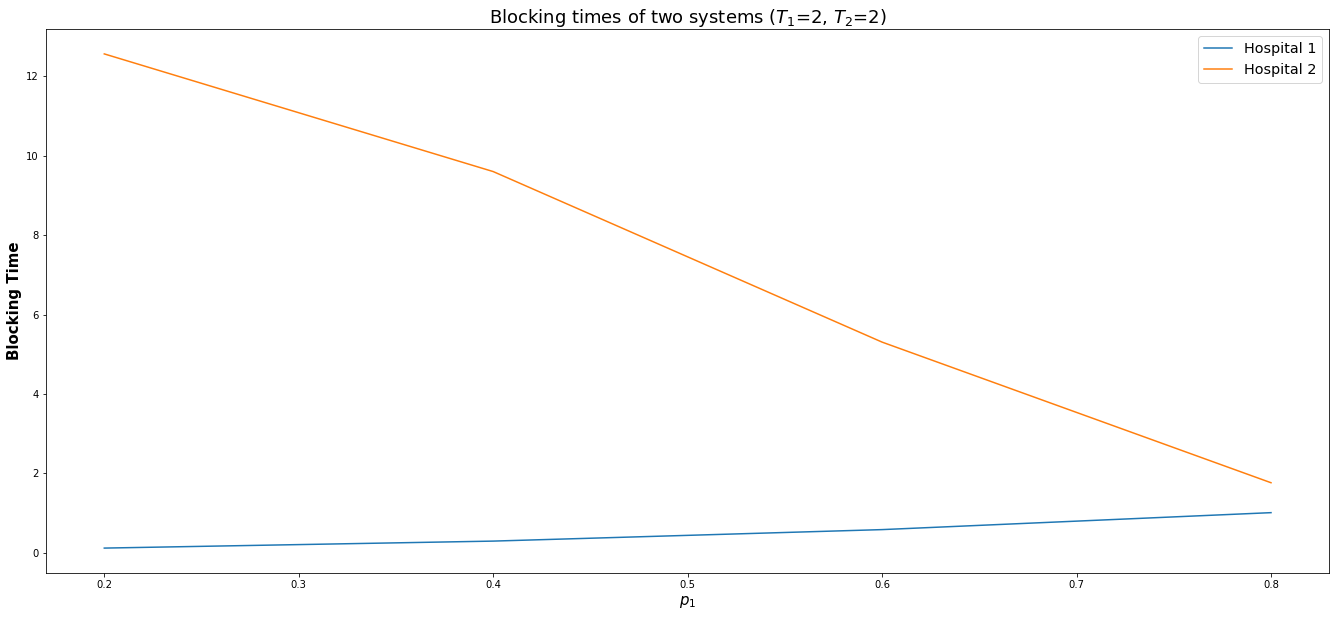

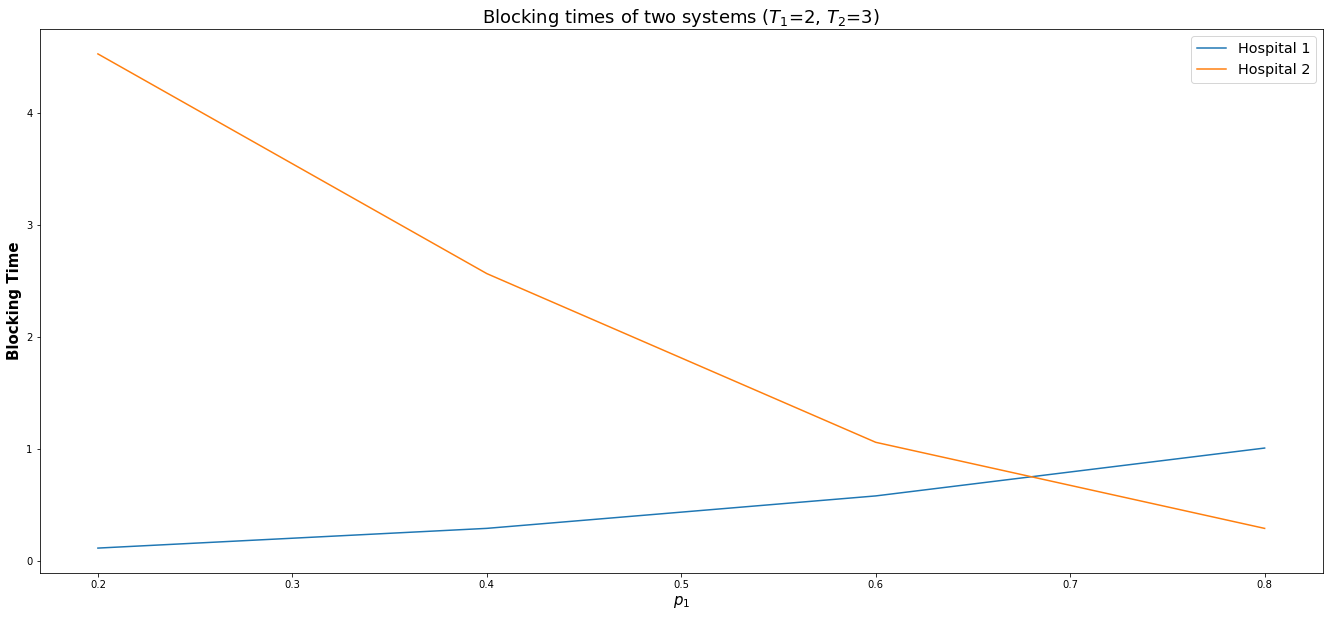

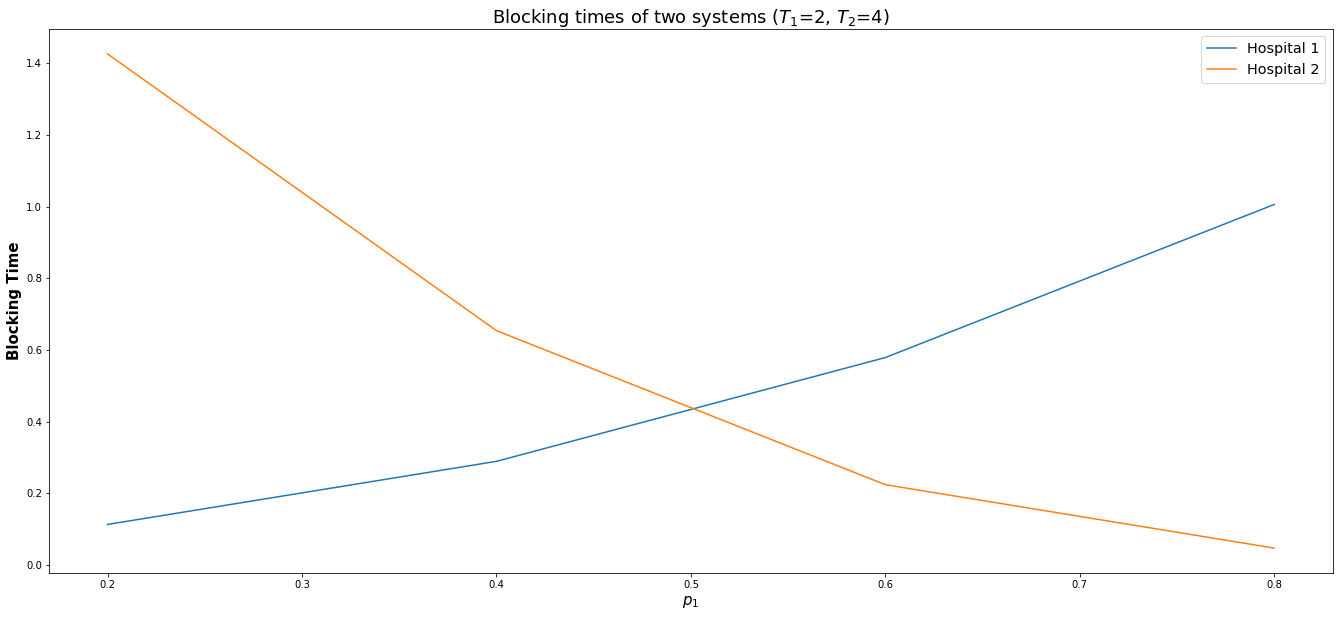

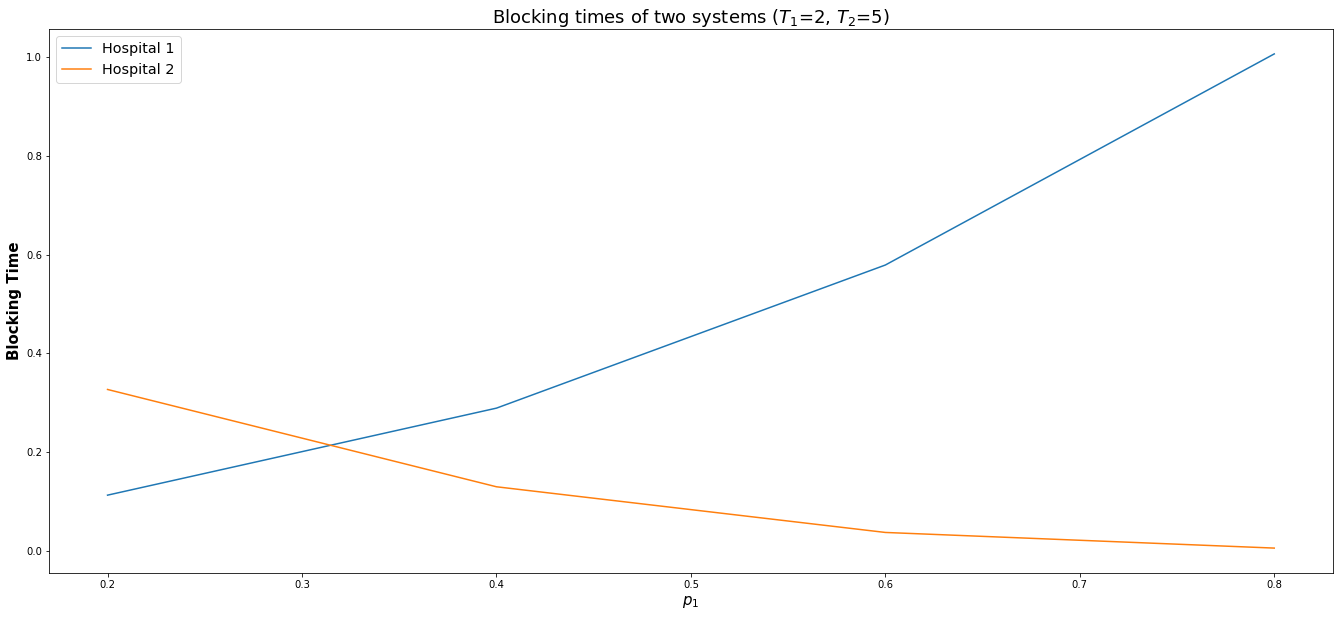

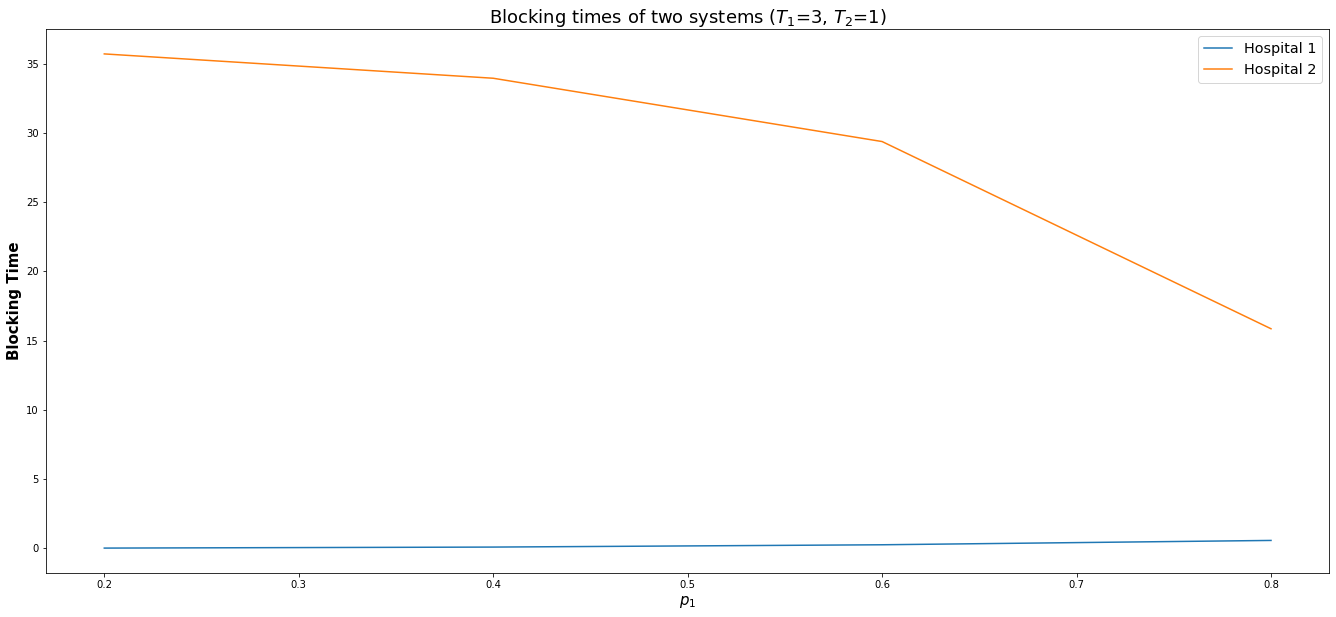

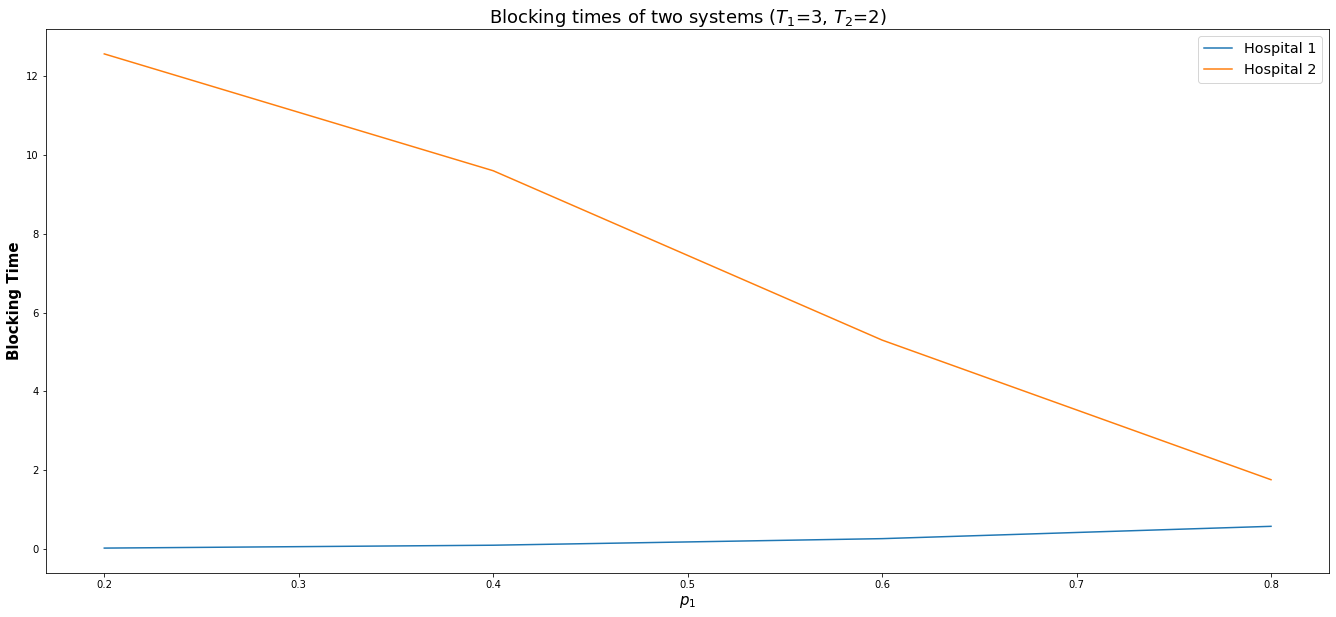

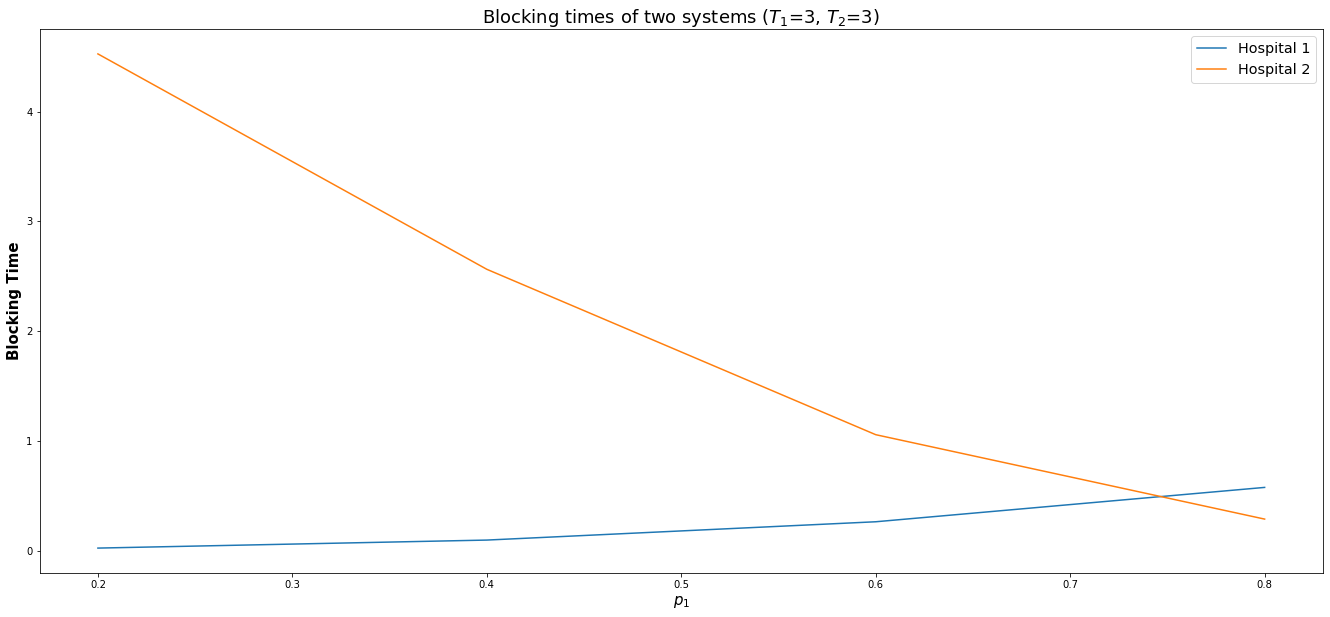

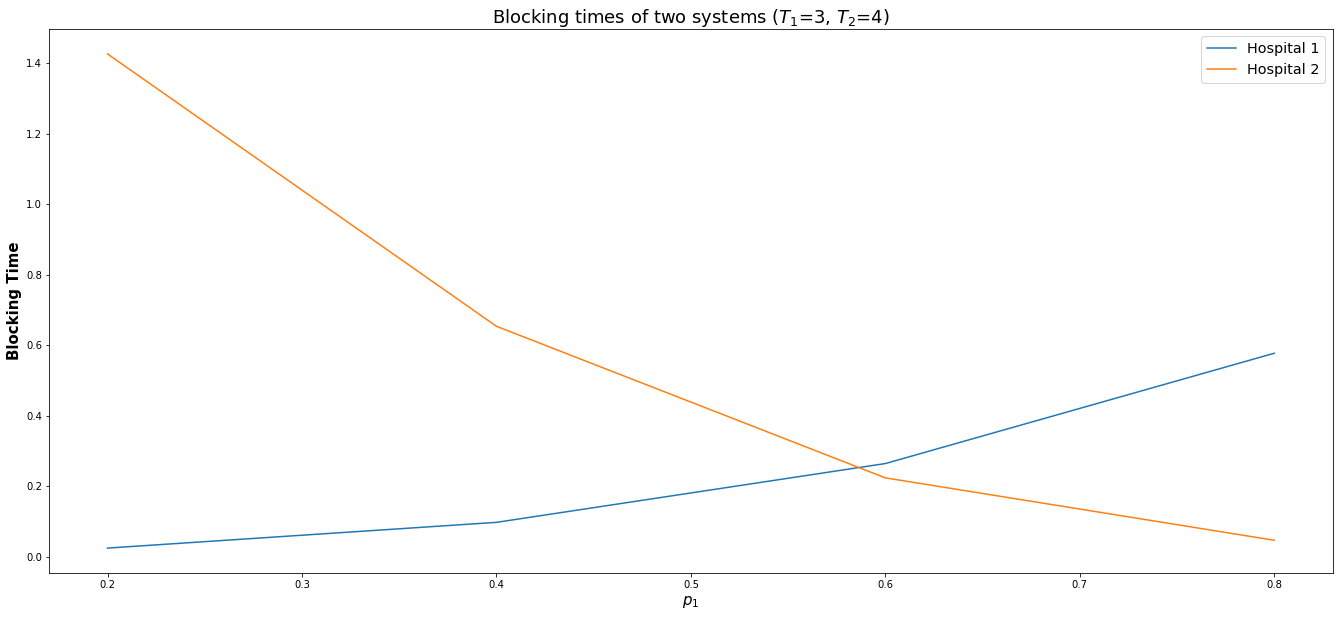

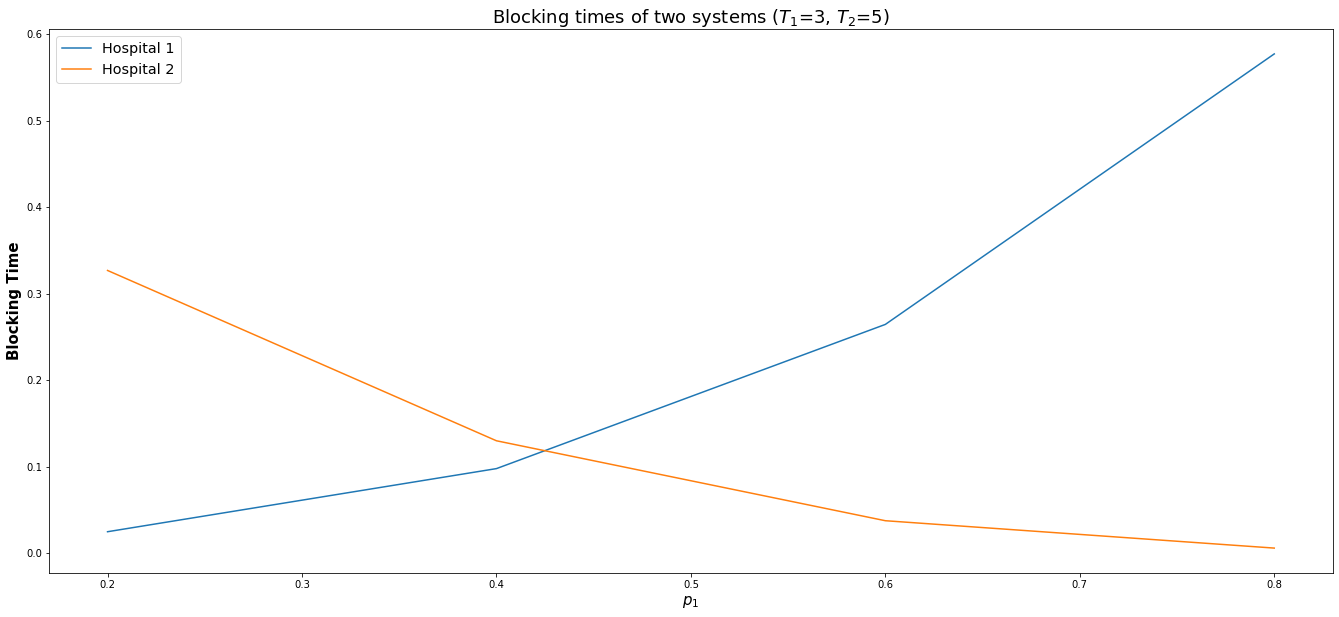

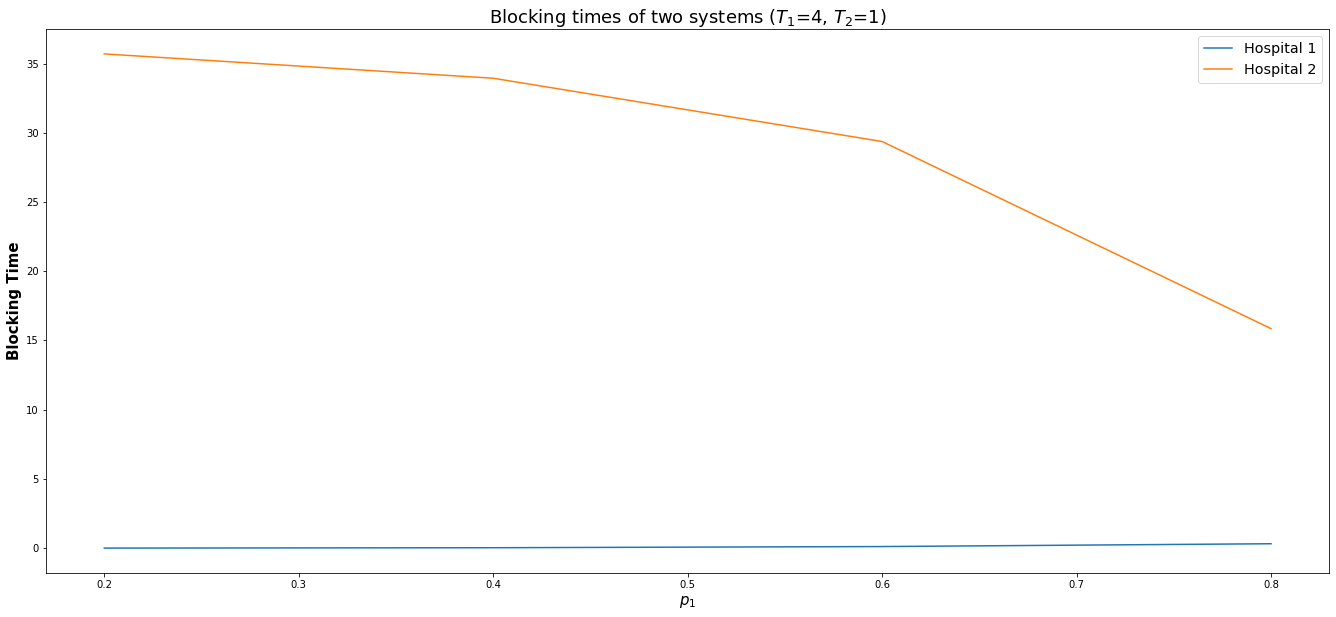

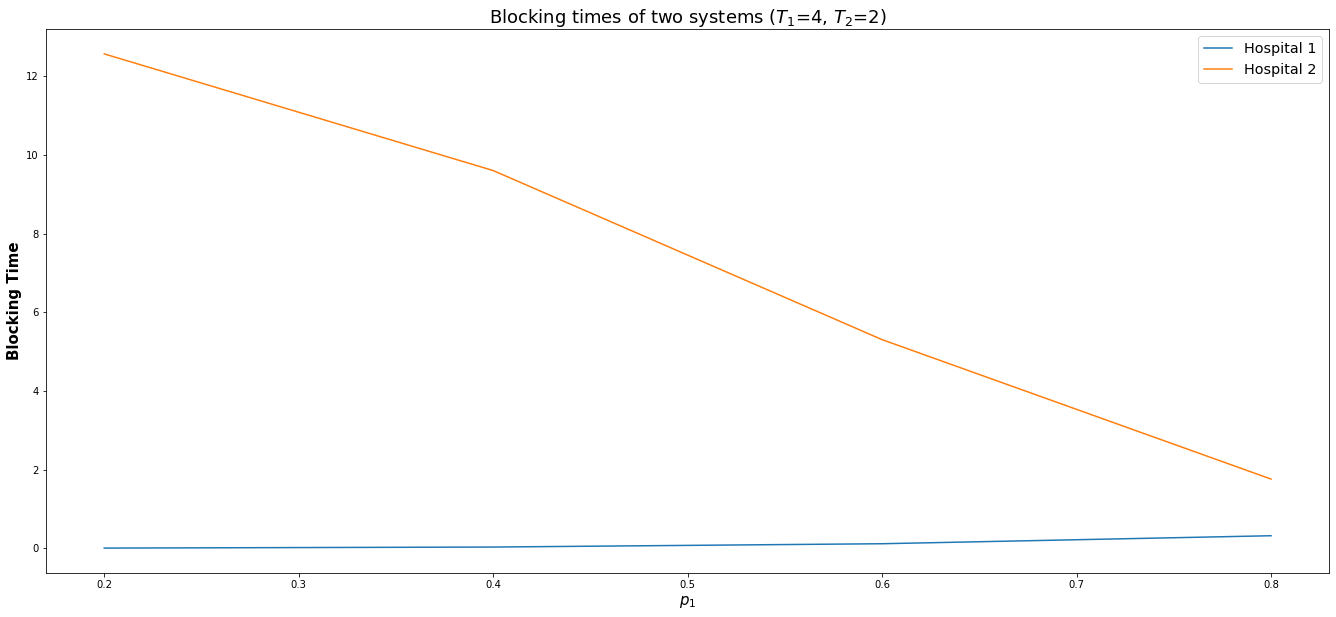

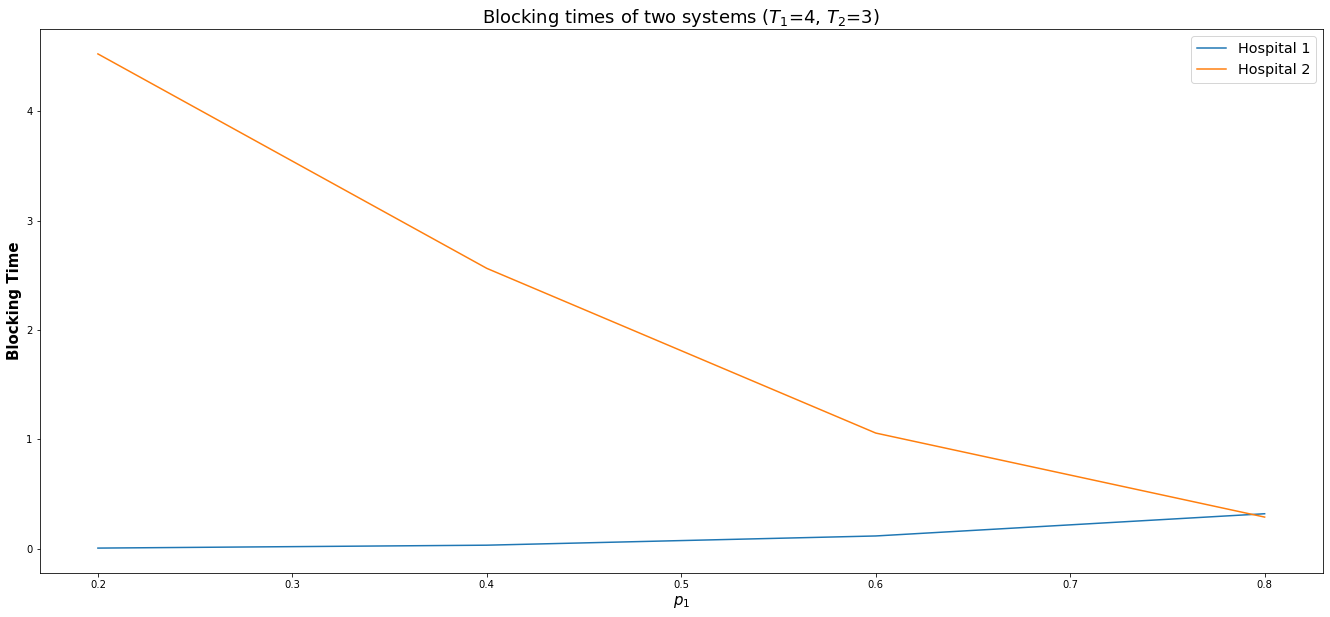

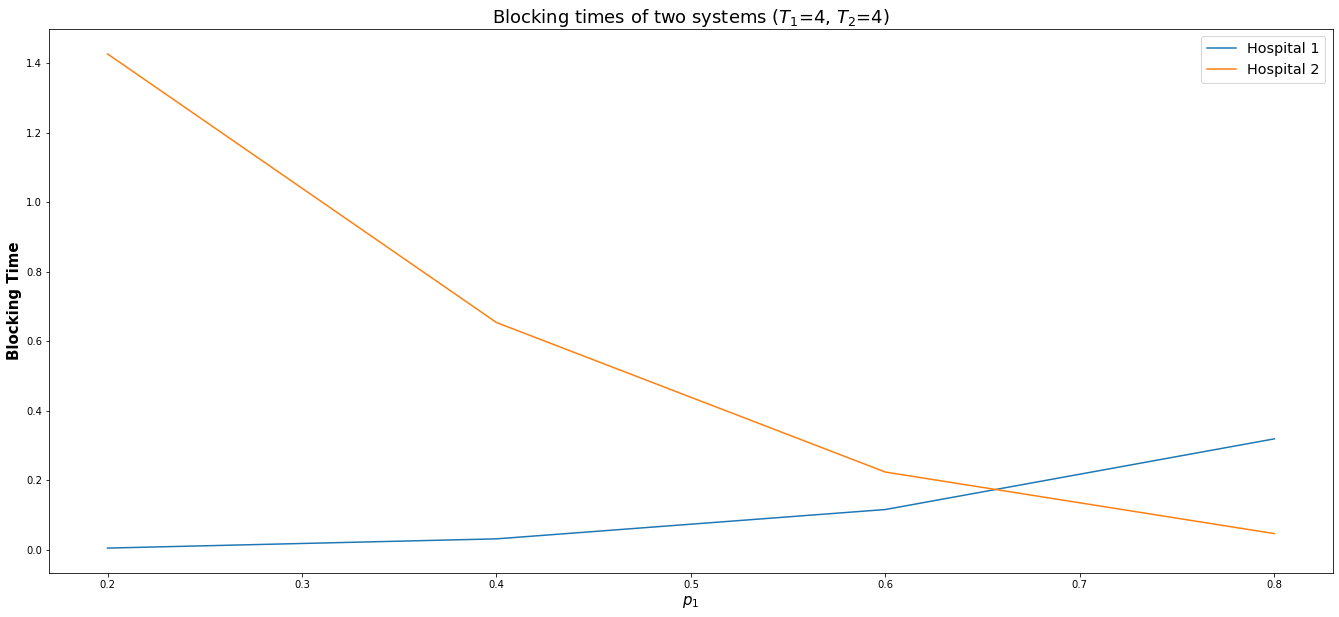

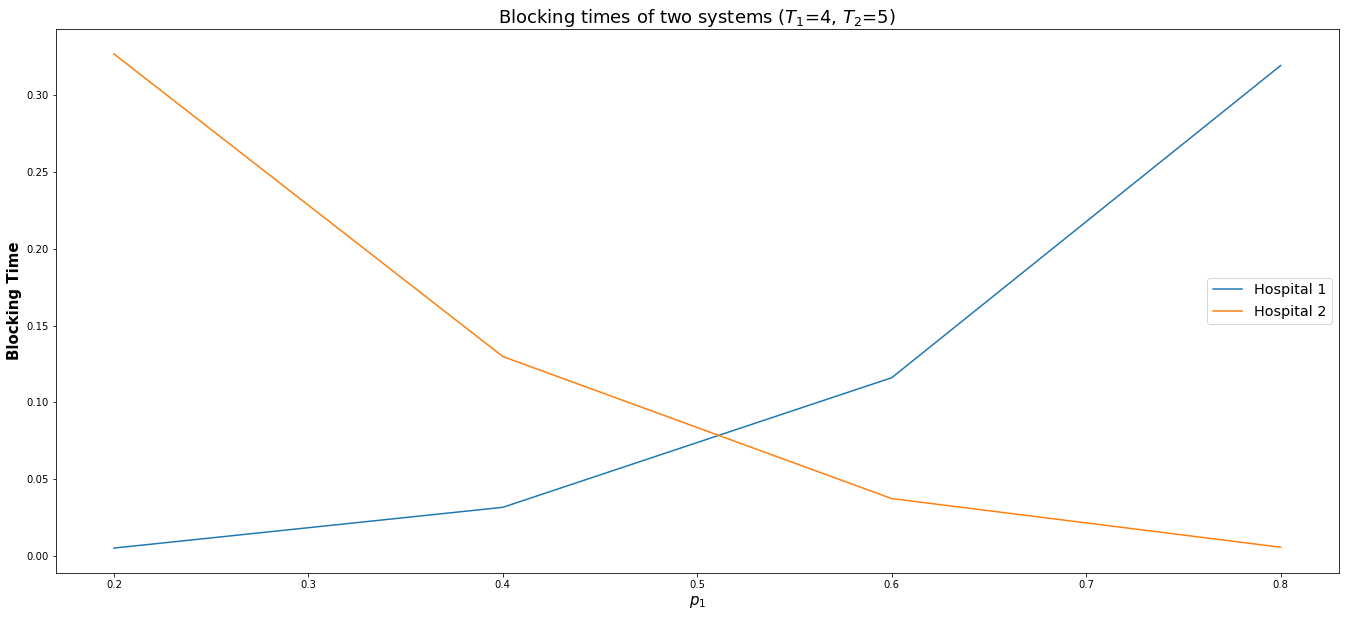

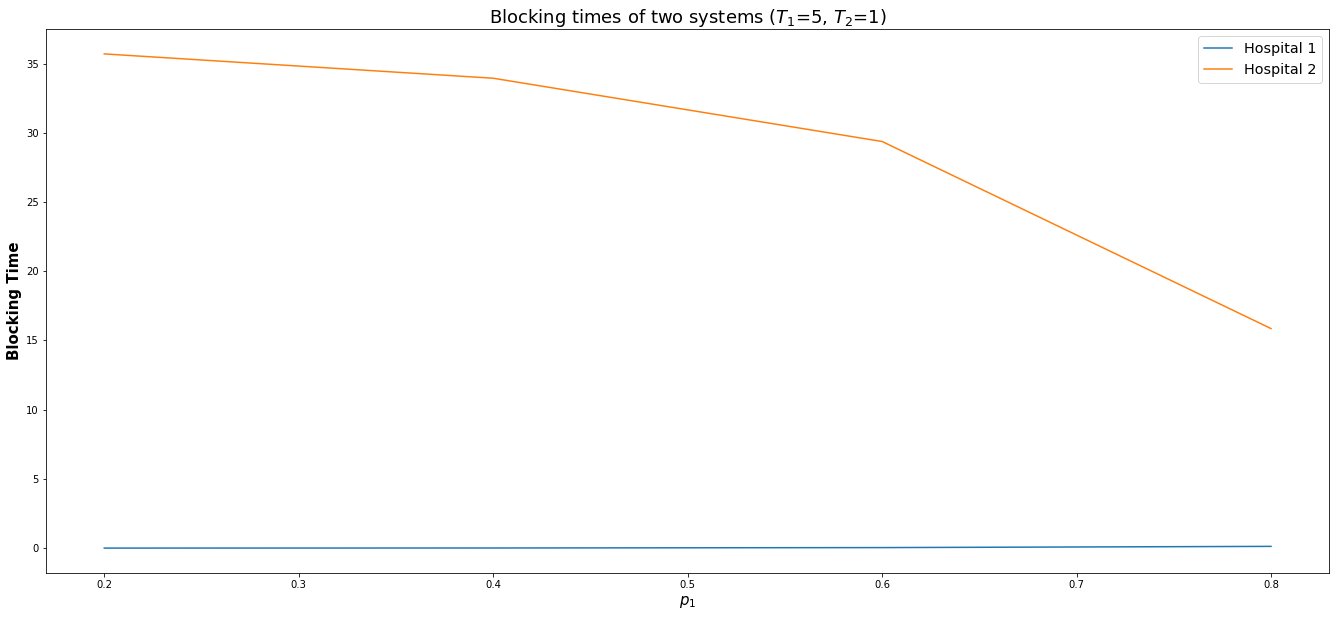

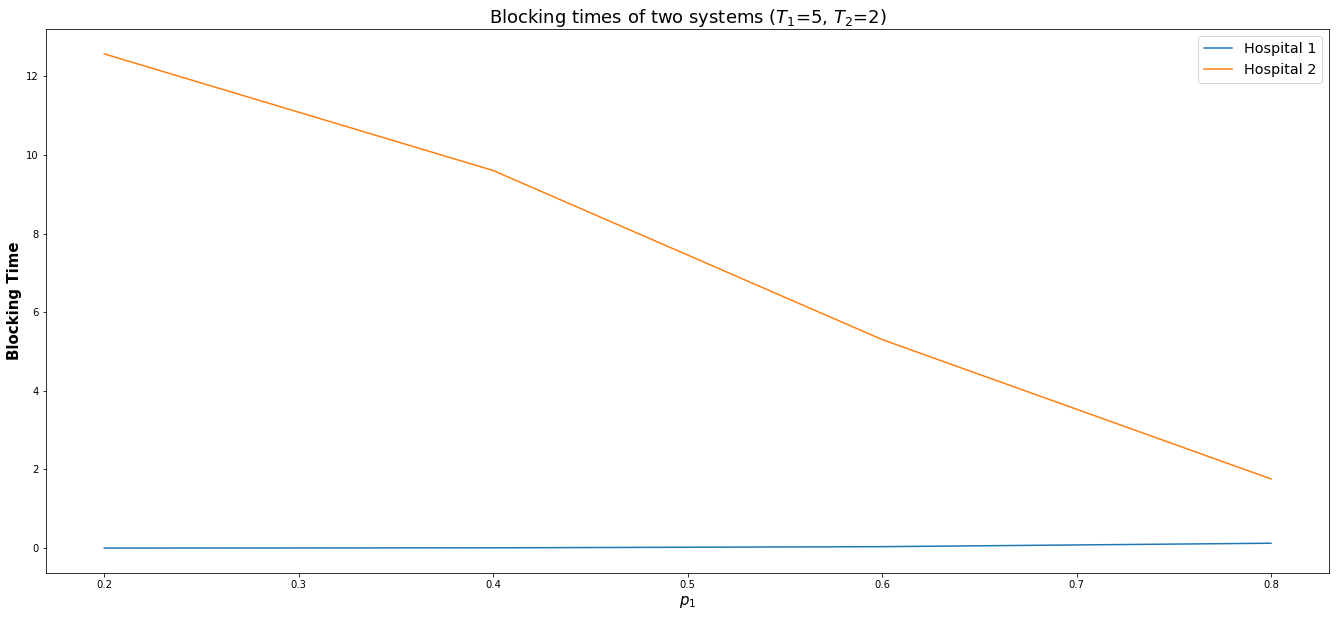

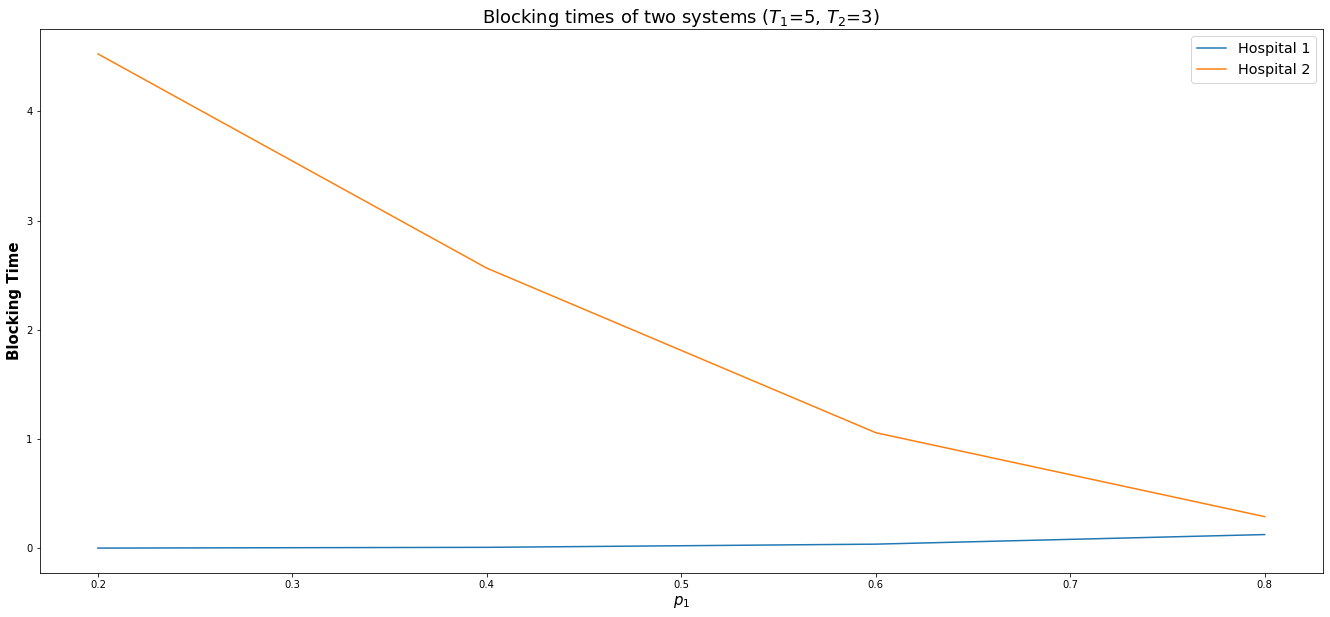

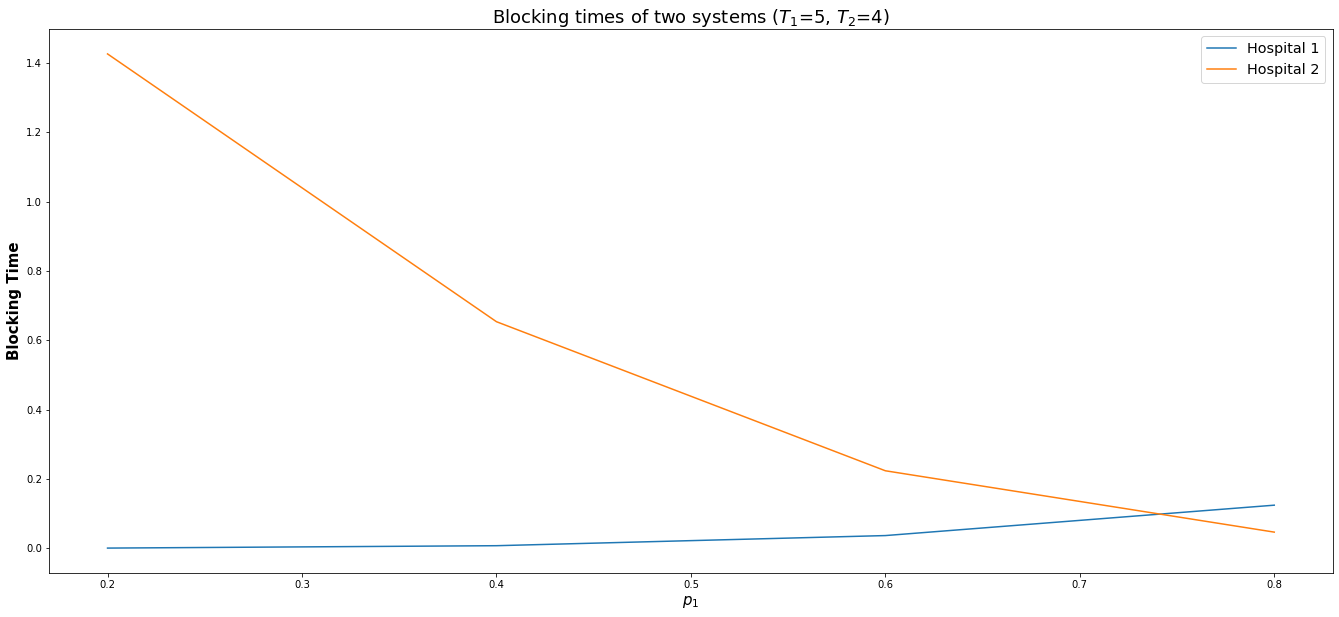

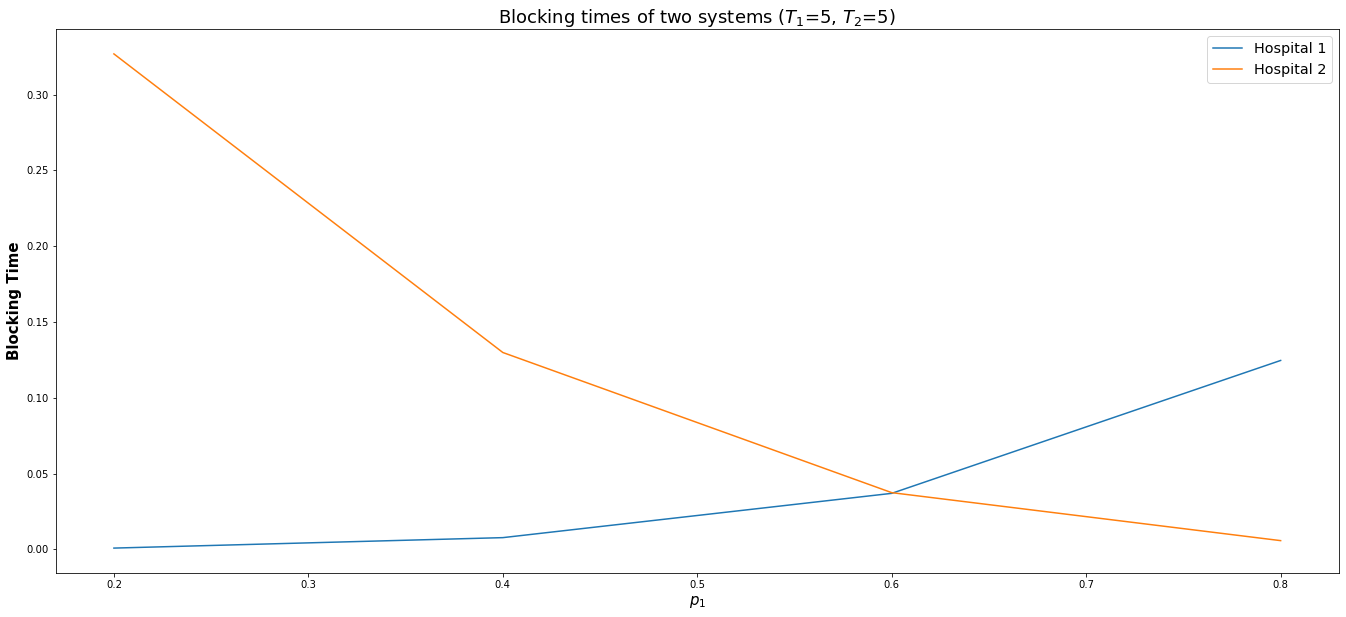

In [62]:
optimal_distribution_array_sim = np.zeros((system_capacity_1, system_capacity_2))
for threshold_1 in range(1, system_capacity_1 + 1):
    for threshold_2 in range(1, system_capacity_2 + 1):
        make_plot_two_hospitals_arrival_split_markov(
            lambda_2=lambda_2,
            lambda_1_1=lambda_1_1,
            lambda_1_2=lambda_1_2,
            mu_1=mu_1,
            mu_2=mu_2,
            num_of_servers_1=num_of_servers_1,
            num_of_servers_2=num_of_servers_2,
            threshold_1=threshold_1,
            threshold_2=threshold_2,
            system_capacity_1=system_capacity_1,
            system_capacity_2=system_capacity_2,
            buffer_capacity_1=buffer_capacity_1,
            buffer_capacity_2=buffer_capacity_2,
            accuracy=5,
        )
        plt.show()

        opt = abg.simulation.calculate_class_2_individuals_best_response(
            lambda_2=lambda_2,
            lambda_1_1=lambda_1_1,
            lambda_1_2=lambda_1_2,
            mu_1=mu_1,
            mu_2=mu_2,
            num_of_servers_1=num_of_servers_1,
            num_of_servers_2=num_of_servers_2,
            system_capacity_1=system_capacity_1,
            system_capacity_2=system_capacity_2,
            buffer_capacity_1=buffer_capacity_1,
            buffer_capacity_2=buffer_capacity_2,
            threshold_1=threshold_1,
            threshold_2=threshold_2,
            seed_num_1=seed_num_1,
            seed_num_2=seed_num_2,
            num_of_trials=num_of_trials,
            warm_up_time=warm_up_time,
            runtime=runtime
            )
        optimal_distribution_array_sim[threshold_1 - 1, threshold_2 - 1] = opt

In [63]:
optimal_distribution_array_sim

array([[0.89611763, 0.56887259, 0.38146243, 0.21144402, 0.03855148],
       [0.98846724, 0.87146892, 0.68538573, 0.50336858, 0.33603533],
       [1.        , 0.88841942, 0.69664916, 0.51135141, 0.40993514],
       [1.        , 0.97279066, 0.79761691, 0.69596312, 0.4870924 ],
       [1.        , 0.98288282, 0.85988809, 0.70868357, 0.61416905]])

## Using Simulation with infinite buffer capacity

In [64]:
optimal_distribution_array_sim_inf = np.zeros((system_capacity_1, system_capacity_2))
for threshold_1 in range(1, system_capacity_1 + 1):
    for threshold_2 in range(1, system_capacity_2 + 1):
        opt = abg.simulation.calculate_class_2_individuals_best_response(
            lambda_2=lambda_2,
            lambda_1_1=lambda_1_1,
            lambda_1_2=lambda_1_2,
            mu_1=mu_1,
            mu_2=mu_2,
            num_of_servers_1=num_of_servers_1,
            num_of_servers_2=num_of_servers_2,
            system_capacity_1=system_capacity_1,
            system_capacity_2=system_capacity_2,
            buffer_capacity_1=float("inf"),
            buffer_capacity_2=float("inf"),
            threshold_1=threshold_1,
            threshold_2=threshold_2,
            seed_num_1=seed_num_1,
            seed_num_2=seed_num_2,
            num_of_trials=num_of_trials,
            warm_up_time=warm_up_time,
            runtime=runtime
            )
        optimal_distribution_array_sim_inf[threshold_1 - 1, threshold_2 - 1] = opt

In [65]:
optimal_distribution_array_sim_inf

array([[0.76327393, 0.59389281, 0.42334313, 0.24104725, 0.        ],
       [0.98881395, 0.901379  , 0.71348293, 0.48901101, 0.24671261],
       [1.        , 0.90929795, 0.69696267, 0.60167052, 0.44730122],
       [1.        , 0.91213388, 0.8355507 , 0.62325819, 0.55285422],
       [1.        , 0.98872763, 0.86571425, 0.73795788, 0.60794636]])

## Using Markov chain

In [15]:
optimal_distribution_array_markov = np.zeros((system_capacity_1, system_capacity_2))
for threshold_1 in range(1, system_capacity_1 + 1):
    for threshold_2 in range(1, system_capacity_2 + 1):
        opt = calculate_class_2_individuals_best_response_markov(
            lambda_2=lambda_2,
            lambda_1_1=lambda_1_1,
            lambda_1_2=lambda_1_2,
            mu_1=mu_1,
            mu_2=mu_2,
            num_of_servers_1=num_of_servers_1,
            num_of_servers_2=num_of_servers_2,
            system_capacity_1=system_capacity_1,
            system_capacity_2=system_capacity_2,
            buffer_capacity_1=buffer_capacity_1,
            buffer_capacity_2=buffer_capacity_2,
            threshold_1=threshold_1,
            threshold_2=threshold_2,
            )
        optimal_distribution_array_markov[threshold_1 - 1, threshold_2 - 1] = opt

In [16]:
optimal_distribution_array_markov

array([[0.8870007 , 0.60492431, 0.38539747, 0.2142945 , 0.04524042],
       [1.        , 0.85797843, 0.66972407, 0.494886  , 0.31287598],
       [1.        , 0.90233743, 0.73709149, 0.58432799, 0.42595625],
       [1.        , 0.94037843, 0.7918947 , 0.65415033, 0.51160716],
       [1.        , 1.        , 0.8604093 , 0.73333747, 0.60086658]])

## Using Markov chain with larger buffer capacity

In [68]:
optimal_distribution_array_markov_large = np.zeros((system_capacity_1, system_capacity_2))
for threshold_1 in range(1, system_capacity_1 + 1):
    for threshold_2 in range(1, system_capacity_2 + 1):
        opt = calculate_class_2_individuals_best_response_markov(
            lambda_2=lambda_2,
            lambda_1_1=lambda_1_1,
            lambda_1_2=lambda_1_2,
            mu_1=mu_1,
            mu_2=mu_2,
            num_of_servers_1=num_of_servers_1,
            num_of_servers_2=num_of_servers_2,
            system_capacity_1=system_capacity_1,
            system_capacity_2=system_capacity_2,
            buffer_capacity_1=50,
            buffer_capacity_2=50,
            threshold_1=threshold_1,
            threshold_2=threshold_2,
            )
        optimal_distribution_array_markov_large[threshold_1 - 1, threshold_2 - 1] = opt

In [69]:
optimal_distribution_array_markov_large

array([[0.76825451, 0.58764299, 0.41338695, 0.24163013, 0.05767329],
       [1.        , 0.84395317, 0.66654118, 0.49683537, 0.31508737],
       [1.        , 0.88620556, 0.73059972, 0.58295063, 0.42621537],
       [1.        , 0.92432501, 0.78427608, 0.65139475, 0.51100355],
       [1.        , 0.98439674, 0.85539168, 0.73119149, 0.60019735]])

# Payoff matrices

\begin{equation}
    U_i =
    \begin{pmatrix}
        G_i(T_1=0, T_2=0, p_i=P_{0,0}) & G_i(T_1=0, T_2=1, p_i=P_{0,1}) & G_i(T_1=0, T_2=2, p_i=P_{0,2}) & \dots & G_i(T_1=0, T_2=N_2, p_i=P_{0,N_2}) \\
        G_i(T_1=1, T_2=0, p_i=P_{1,0}) & G_i(T_1=1, T_2=1, p_i=P_{1,1}) & G_i(T_1=1, T_2=2, p_i=P_{1,2}) & \dots & G_i(T_1=1, T_2=N_2, p_i=P_{1,N_2}) \\
        G_i(T_1=2, T_2=0, p_i=P_{2,0}) & G_i(T_1=2, T_2=1, p_i=P_{2,1}) & G_i(T_1=2, T_2=2, p_i=P_{2,2}) & \dots & G_i(T_1=2, T_2=N_2, p_i=P_{2,N_2}) \\
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        G_i(T_1=N_1-1, T_2=0, p_i=P_{N_1-1,0}) & G_i(T_1=N_1-1, T_2=1, p_i=P_{N_1-1,1}) & G_i(T_1=N_1-1, T_2=2, p_i=P_{N_1-1,2}) & \dots & G_i(T_1=N_1-1, T_2=N_2, p_i=P_{N_1-1,N_2}) \\
        G_i(T_1=N_1, T_2=0, p_i=P_{N_1,0}) & G_i(T_1=N_1, T_2=1, p_i=P_{N_1,1}) & G_i(T_1=N_1, T_2=2, p_i=P_{N_1,2}) & \dots & G_i(T_1=N_1, T_2=N_2, p_i=P_{N_1,N_2}) 
    \end{pmatrix}
\end{equation}


\begin{equation}
    G_1(T_1, T_2) = - W_1 \\
    G_2(T_1, T_2) = - W_2 
\end{equation}

In [27]:
utility_matrix_1 = np.zeros((system_capacity_1, system_capacity_2))
utility_matrix_2 = np.zeros((system_capacity_1, system_capacity_2))
for threshold_1 in range(1, system_capacity_1 + 1):
    for threshold_2 in range(1, system_capacity_2 + 1):
        p1 = optimal_distribution_array_markov[threshold_2 - 1, threshold_1 - 1]
        p2 = 1 - p1
        wait_1 = abg.markov.get_mean_waiting_time_using_markov_state_probabilities(
            lambda_2=lambda_2 * p1, 
            lambda_1=lambda_1_1, 
            mu=mu_1, 
            num_of_servers=num_of_servers_1, 
            threshold=threshold_1, 
            system_capacity=system_capacity_1, 
            buffer_capacity=buffer_capacity_1,
        )
        wait_2 = abg.markov.get_mean_waiting_time_using_markov_state_probabilities(
            lambda_2=lambda_2 * p2, 
            lambda_1=lambda_1_2, 
            mu=mu, 
            num_of_servers=num_of_servers, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity,
        )
        utility_matrix_1[threshold_1 - 1, threshold_2 - 1] = -wait_1
        utility_matrix_2[threshold_1 - 1, threshold_2 - 1] = -wait_2

In [30]:
utility_matrix_1

array([[-0.02012764, -0.02012764, -0.02012764, -0.02012764, -0.02012764],
       [-0.06998866, -0.08373161, -0.08578091, -0.08745329, -0.08991675],
       [-0.18242838, -0.3698211 , -0.41934935, -0.46045635, -0.51240366],
       [-0.10581241, -0.32079687, -0.41370439, -0.4941466 , -0.59332187],
       [-0.03265359, -0.17251094, -0.26778984, -0.35532942, -0.46119141]])

In [29]:
utility_matrix_2

array([[-2.60914254e-04, -9.26183199e-05, -9.26183199e-05,
        -9.26183199e-05, -9.26183199e-05],
       [-1.05517791e-03, -3.17931048e-04, -2.33062657e-04,
        -1.70775337e-04, -9.26183199e-05],
       [-2.04710032e-03, -8.25211036e-04, -6.16253308e-04,
        -4.68838592e-04, -3.12938771e-04],
       [-3.05104922e-03, -1.51111705e-03, -1.13424087e-03,
        -8.77882627e-04, -6.27091487e-04],
       [-4.24537906e-03, -2.44770452e-03, -1.83892903e-03,
        -1.43650728e-03, -1.07052619e-03]])

## Game

In [31]:
hospital_game = nash.Game(utility_matrix_1, utility_matrix_2)
hospital_game

Bi matrix game with payoff matrices:

Row player:
[[-0.02012764 -0.02012764 -0.02012764 -0.02012764 -0.02012764]
 [-0.06998866 -0.08373161 -0.08578091 -0.08745329 -0.08991675]
 [-0.18242838 -0.3698211  -0.41934935 -0.46045635 -0.51240366]
 [-0.10581241 -0.32079687 -0.41370439 -0.4941466  -0.59332187]
 [-0.03265359 -0.17251094 -0.26778984 -0.35532942 -0.46119141]]

Column player:
[[-2.60914254e-04 -9.26183199e-05 -9.26183199e-05 -9.26183199e-05
  -9.26183199e-05]
 [-1.05517791e-03 -3.17931048e-04 -2.33062657e-04 -1.70775337e-04
  -9.26183199e-05]
 [-2.04710032e-03 -8.25211036e-04 -6.16253308e-04 -4.68838592e-04
  -3.12938771e-04]
 [-3.05104922e-03 -1.51111705e-03 -1.13424087e-03 -8.77882627e-04
  -6.27091487e-04]
 [-4.24537906e-03 -2.44770452e-03 -1.83892903e-03 -1.43650728e-03
  -1.07052619e-03]]

In [32]:
list(hospital_game.support_enumeration())

[(array([1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0.])),
 (array([1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0.])),
 (array([1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0.])),
 (array([1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1.]))]